### Import the libraries

In [8]:
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import f1_score, silhouette_samples, silhouette_score, homogeneity_completeness_v_measure
from sklearn.model_selection import learning_curve
from sklearn.decomposition import PCA, FastICA
from sklearn.neural_network import MLPClassifier
from sklearn.random_projection import GaussianRandomProjection
from sklearn import manifold
from matplotlib import offsetbox
import statistics
from scipy.stats import kurtosis
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Get and clean the datasets

In [2]:
ds_diabetes = pd.read_csv('diabetes.csv')
ds_diabetes.dropna(inplace=True)

### Display the datasets

array([[<AxesSubplot:title={'center':'Pregnancies'}>,
        <AxesSubplot:title={'center':'Glucose'}>,
        <AxesSubplot:title={'center':'BloodPressure'}>],
       [<AxesSubplot:title={'center':'SkinThickness'}>,
        <AxesSubplot:title={'center':'Insulin'}>,
        <AxesSubplot:title={'center':'BMI'}>],
       [<AxesSubplot:title={'center':'DiabetesPedigreeFunction'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Outcome'}>]], dtype=object)

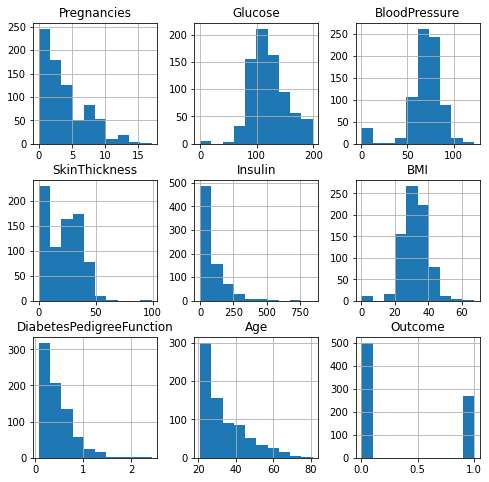

In [3]:
ds_diabetes.hist(figsize=(8,8))

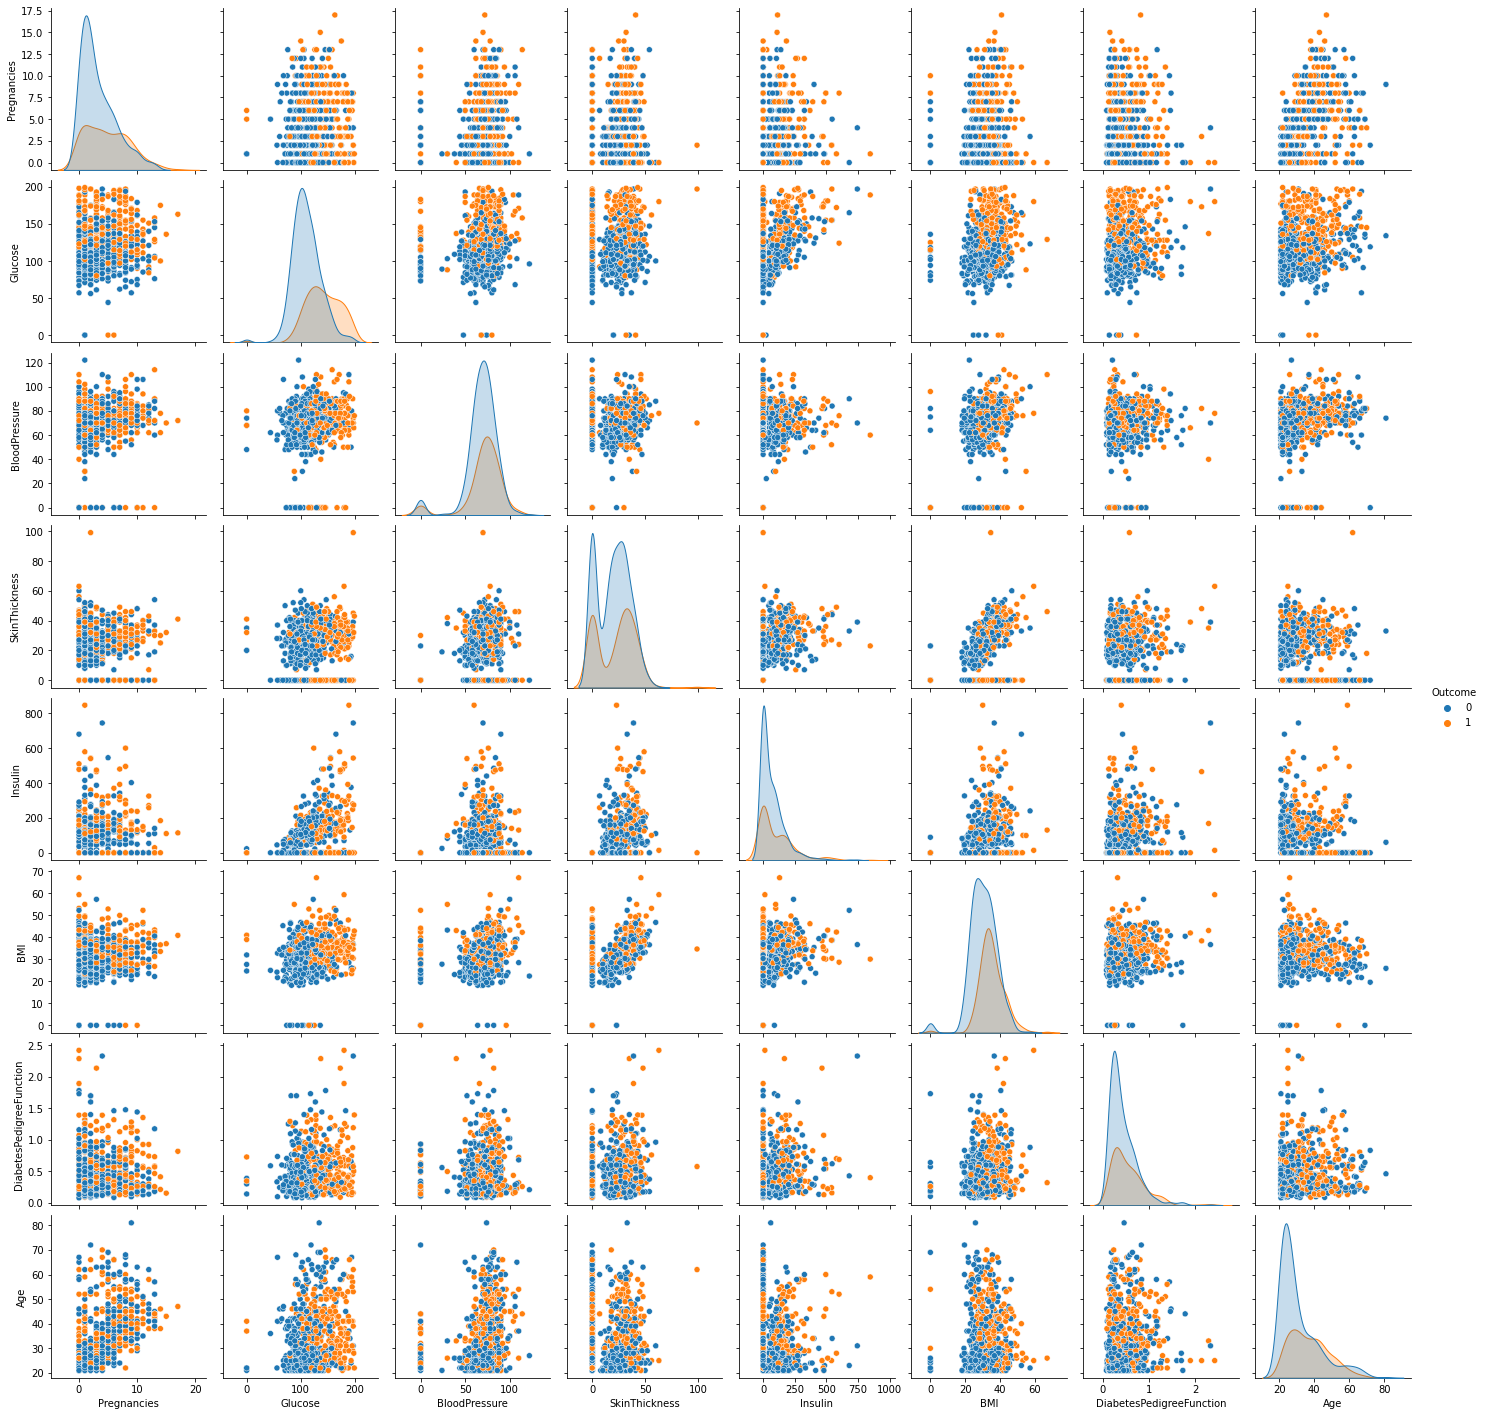

In [4]:
sns.pairplot(ds_diabetes, hue='Outcome')

### Preprocessing the data

In [5]:
ds_diabetes = ds_diabetes.loc[ds_diabetes.BloodPressure != 0,:]
ds_diabetes = ds_diabetes.loc[ds_diabetes.Glucose != 0,:]
ds_diabetes = ds_diabetes.loc[ds_diabetes.BMI != 0,:]

train_ds_diabetes, test_ds_diabetes = train_test_split(ds_diabetes, train_size=0.75, random_state=0, stratify=ds_diabetes['Outcome'])

y_train_diabetes = train_ds_diabetes.Outcome.reset_index(drop=True)
X_train_diabetes = train_ds_diabetes.drop('Outcome', axis=1)
y_test_diabetes = test_ds_diabetes.Outcome.reset_index(drop=True)
X_test_diabetes = test_ds_diabetes.drop('Outcome', axis=1)

scaler = preprocessing.StandardScaler().fit(X_train_diabetes)
X_train_diabetes = pd.DataFrame(data=scaler.transform(X_train_diabetes),columns=X_train_diabetes.columns)
X_test_diabetes = pd.DataFrame(data=scaler.transform(X_test_diabetes),columns=X_test_diabetes.columns)

### Clustering algorithms

# Dimensionnality Reduction

# PCA

### Training

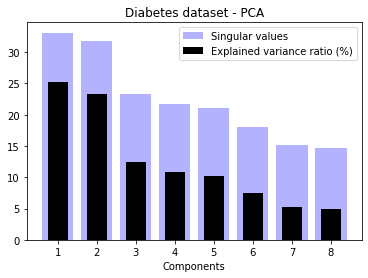

In [41]:
pca = PCA(n_components=0.999)
pca.fit(X_train_diabetes)
plt.bar(range(1, pca.n_features_+1), pca.singular_values_, color='blue', alpha=0.3, label="Singular values")
plt.bar(range(1, pca.n_features_+1), 100*pca.explained_variance_ratio_, color='black', width=0.5, label="Explained variance ratio (%)")
plt.xlabel('Components')
plt.title('Diabetes dataset - PCA')
plt.legend()

### Evaluating

0.00841665267944336


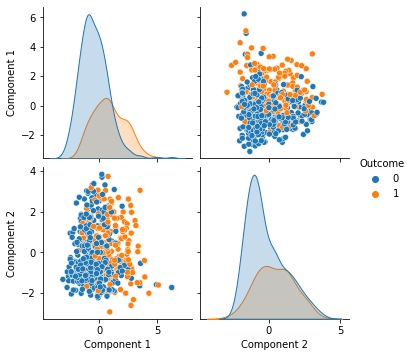

In [29]:
pca = PCA(n_components=2)
t1 = time.time()
pca.fit(X_train_diabetes)
print(time.time()-t1)
X_pca_diabetes = pd.DataFrame(pca.transform(X_train_diabetes), columns=['Component '+str(i) for i in range(1, pca.n_components_+1)])
X_pca_diabetes['Outcome'] = y_train_diabetes
sns.pairplot(X_pca_diabetes, hue='Outcome')

### Neural Network

0 1 2 3 4 5 

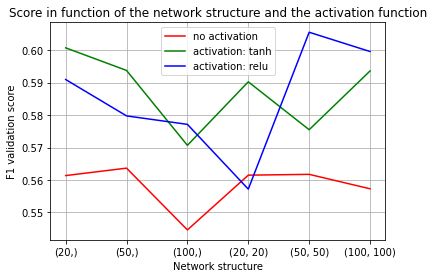

In [7]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
def select_neural_network(X_train, y_train, structures=[(20,), (50,),(100,),(20,20),(50,50,),(100,100,)], fit_per_step=3, multiclass='binary'):
    val_scores = np.zeros(len(structures))
    val_scores2 = np.zeros(len(structures))
    val_scores3 = np.zeros(len(structures))
    for i, structure in enumerate(structures):
        print(i, end=' ')
        for _ in range(fit_per_step):
            NN = MLPClassifier(hidden_layer_sizes=structure, learning_rate_init=0.01 if len(structure)==1 else 0.001, activation='identity', max_iter=60)
            cross_val = cross_validate(NN, X_train, y_train, cv=5, scoring='f1')
            val_scores[i] += statistics.mean(cross_val['test_score']) 
            NN = MLPClassifier(hidden_layer_sizes=structure, learning_rate_init=0.01 if len(structure)==1 else 0.001, activation='tanh', max_iter=60)
            cross_val = cross_validate(NN, X_train, y_train, cv=5, scoring='f1')
            val_scores2[i] += statistics.mean(cross_val['test_score'])
            NN = MLPClassifier(hidden_layer_sizes=structure, learning_rate_init=0.01 if len(structure)==1 else 0.001, activation='relu', max_iter=60)
            cross_val = cross_validate(NN, X_train, y_train, cv=5, scoring='f1')
            val_scores3[i] += statistics.mean(cross_val['test_score'])
        val_scores[i] /= fit_per_step
        val_scores2[i] /= fit_per_step
        val_scores3[i] /= fit_per_step
    plt.figure()
    plt.plot([str(s) for s in structures], val_scores, 'red', label='no activation')
    plt.plot([str(s) for s in structures], val_scores2, 'green', label='activation: tanh')
    plt.plot([str(s) for s in structures], val_scores3, 'blue', label='activation: relu')
    plt.title('Score in function of the network structure and the activation function')
    plt.xlabel('Network structure')
    plt.ylabel('F1 validation score')
    plt.legend()
    plt.grid()
    
pca = PCA(n_components=0.8)
pca.fit(X_train_diabetes)
X_train = pd.DataFrame(pca.transform(X_train_diabetes), columns=['Component '+str(i) for i in range(1, pca.n_components_+1)])
y_train = np.array(y_train_diabetes)
select_neural_network(X_train, y_train, multiclass='binary')

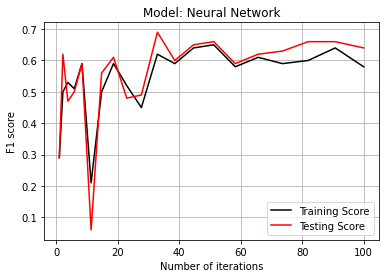

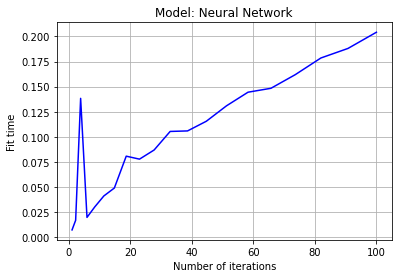

In [9]:
from sklearn.metrics import accuracy_score as accuracy
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
pca = PCA(n_components=0.8)
pca.fit(X_train_diabetes)
X_train = pd.DataFrame(pca.transform(X_train_diabetes), columns=['Component '+str(i) for i in range(1, pca.n_components_+1)])
X_test = pd.DataFrame(pca.transform(X_test_diabetes), columns=['Component '+str(i) for i in range(1, pca.n_components_+1)])
y_train = np.array(y_train_diabetes)
y_test = np.array(y_test_diabetes)
n = 20
I = 100*(np.linspace(0.1,1,n))**2
train_time = np.zeros(n)
train_score = np.zeros(n)
val_score = np.zeros(n)
for c,i in enumerate(I):
    NN = MLPClassifier(hidden_layer_sizes=(20,), learning_rate_init=0.001, activation='tanh', max_iter=int(i))
    t1 = time.time()
    NN.fit(X_train,y_train)
    t2 = time.time()
    train_time[c] = t2-t1
    train_score[c] = round(f1_score(NN.predict(X_train),y_train, average='binary'),2)
    val_score[c] = round(f1_score(NN.predict(X_test),y_test, average='binary'),2)
plt.figure()
plt.plot(I, train_score, 'black', label='Training Score')
plt.plot(I, val_score, 'red', label='Testing Score')
plt.title('Model: Neural Network')
plt.xlabel('Number of iterations')
plt.ylabel('F1 score')
plt.legend()
plt.grid()

plt.figure()
plt.plot(I, train_time, 'blue')
plt.title('Model: Neural Network')
plt.xlabel('Number of iterations')
plt.ylabel('Fit time')
plt.grid()

# ICA

### Training

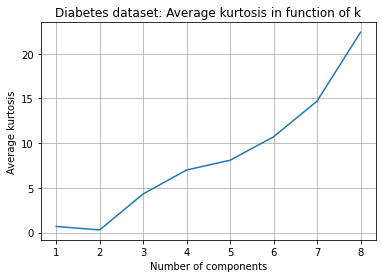

In [45]:
def kurtosis_ICA(points, N):
    l_kurtosis = []
    for n in range(1, 1+N):
        ica = FastICA(n_components=n, max_iter = 1000)
        ica.fit(points)
        results = pd.DataFrame(ica.transform(points), columns=range(1,n+1))
        l_kurtosis.append(np.sum([kurtosis(results.loc[:,i]) for i in range(1,n+1)]))
    return l_kurtosis

N = len(X_train_diabetes.columns)
plt.title('Diabetes dataset: Average kurtosis in function of k')
plt.xlabel('Number of components')
plt.ylabel('Average kurtosis')
plt.grid()
plt.plot(range(1, N+1), kurtosis_ICA(X_train_diabetes, N))

### Evaluating

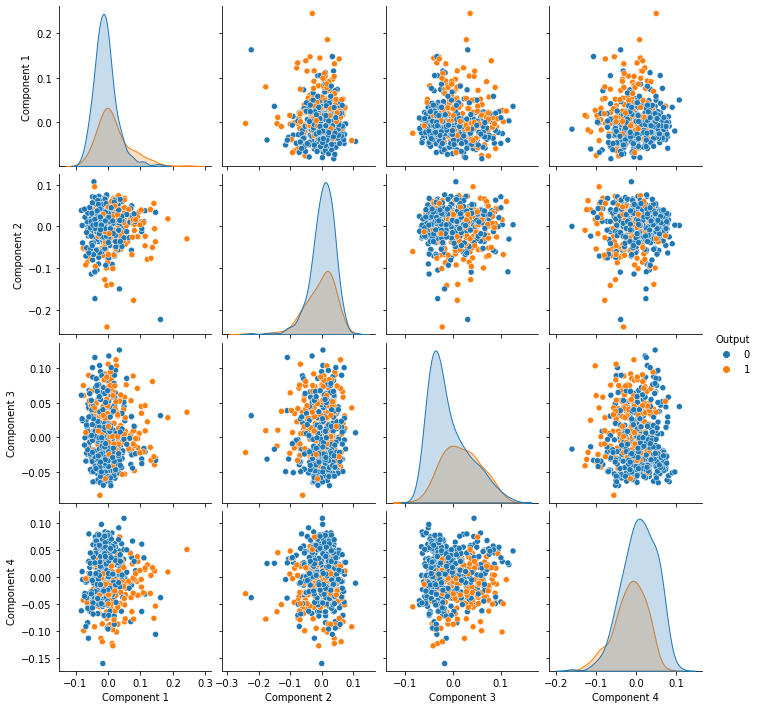

In [11]:
ica = FastICA(n_components=4)
ica.fit(X_train_diabetes)
X_ica_diabetes = pd.DataFrame(ica.transform(X_train_diabetes), columns=['Component '+str(i) for i in range(1, 4+1)])
X_ica_diabetes['Output'] = y_train_diabetes
sns.pairplot(X_ica_diabetes, hue='Output')

In [13]:
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y_train_diabetes[i]),
                 color=plt.cm.Set1(y_train_diabetes[i] / 2.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            #imagebox = offsetbox.AnnotationBbox(
                #offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),X[i])
            #ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

0.008174657821655273


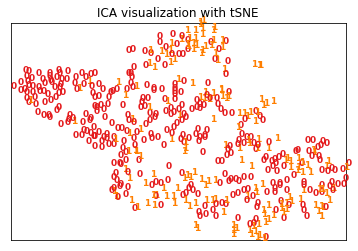

In [19]:
ica = FastICA(n_components=4)
t1 = time.time()
ica.fit(X_train_diabetes)
print(time.time()-t1)
X_ica_diabetes = pd.DataFrame(ica.transform(X_train_diabetes), columns=['Component '+str(i) for i in range(1, 4+1)])
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X_ica_diabetes)
plot_embedding(X_tsne, title="ICA visualization with tSNE")

### Neural Network

0 1 2 3 4 5 

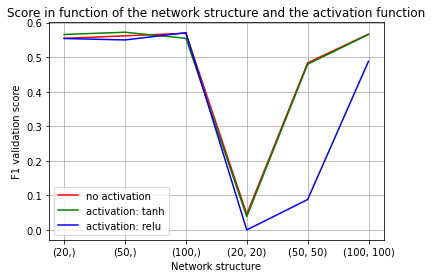

In [12]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
def select_neural_network(X_train, y_train, structures=[(20,), (50,),(100,),(20,20),(50,50,),(100,100,)], fit_per_step=3, multiclass='binary'):
    val_scores = np.zeros(len(structures))
    val_scores2 = np.zeros(len(structures))
    val_scores3 = np.zeros(len(structures))
    for i, structure in enumerate(structures):
        print(i, end=' ')
        for _ in range(fit_per_step):
            NN = MLPClassifier(hidden_layer_sizes=structure, learning_rate_init=0.01 if len(structure)==1 else 0.001, activation='identity', max_iter=60)
            cross_val = cross_validate(NN, X_train, y_train, cv=5, scoring='f1')
            val_scores[i] += statistics.mean(cross_val['test_score']) 
            NN = MLPClassifier(hidden_layer_sizes=structure, learning_rate_init=0.01 if len(structure)==1 else 0.001, activation='tanh', max_iter=60)
            cross_val = cross_validate(NN, X_train, y_train, cv=5, scoring='f1')
            val_scores2[i] += statistics.mean(cross_val['test_score'])
            NN = MLPClassifier(hidden_layer_sizes=structure, learning_rate_init=0.01 if len(structure)==1 else 0.001, activation='relu', max_iter=60)
            cross_val = cross_validate(NN, X_train, y_train, cv=5, scoring='f1')
            val_scores3[i] += statistics.mean(cross_val['test_score'])
        val_scores[i] /= fit_per_step
        val_scores2[i] /= fit_per_step
        val_scores3[i] /= fit_per_step
    plt.figure()
    plt.plot([str(s) for s in structures], val_scores, 'red', label='no activation')
    plt.plot([str(s) for s in structures], val_scores2, 'green', label='activation: tanh')
    plt.plot([str(s) for s in structures], val_scores3, 'blue', label='activation: relu')
    plt.title('Score in function of the network structure and the activation function')
    plt.xlabel('Network structure')
    plt.ylabel('F1 validation score')
    plt.legend()
    plt.grid()
ica = FastICA(n_components=4)
ica.fit(X_train_diabetes)
X_train = pd.DataFrame(ica.transform(X_train_diabetes), columns=['Component '+str(i) for i in range(1, 4+1)])
y_train = np.array(y_train_diabetes)
select_neural_network(X_train, y_train, multiclass='binary')

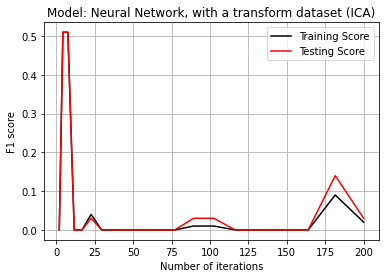

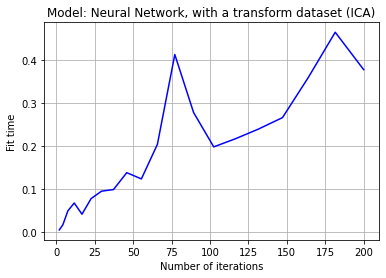

In [58]:
from sklearn.metrics import accuracy_score as accuracy
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
ica = FastICA(n_components=4)
ica.fit(X_train_diabetes)
X_train = pd.DataFrame(ica.transform(X_train_diabetes), columns=['Component '+str(i) for i in range(1, 4+1)])
X_test = pd.DataFrame(ica.transform(X_test_diabetes), columns=['Component '+str(i) for i in range(1, 4+1)])
y_train = np.array(y_train_diabetes)
y_test = np.array(y_test_diabetes)
n = 20
I = 200*(np.linspace(0.1,1,n))**2
train_time = np.zeros(n)
train_score = np.zeros(n)
val_score = np.zeros(n)
for c,i in enumerate(I):
    NN = MLPClassifier(hidden_layer_sizes=(20), learning_rate_init=0.001, activation='relu', max_iter=int(i))
    t1 = time.time()
    NN.fit(X_train,y_train)
    t2 = time.time()
    train_time[c] = t2-t1
    train_score[c] = round(f1_score(NN.predict(X_train),y_train, average='binary'),2)
    val_score[c] = round(f1_score(NN.predict(X_test),y_test, average='binary'),2)
plt.figure()
plt.plot(I, train_score, 'black', label='Training Score')
plt.plot(I, val_score, 'red', label='Testing Score')
plt.title('Model: Neural Network, with a transform dataset (ICA)')
plt.xlabel('Number of iterations')
plt.ylabel('F1 score')
plt.legend()
plt.grid()

plt.figure()
plt.plot(I, train_time, 'blue')
plt.title('Model: Neural Network, with a transform dataset (ICA)')
plt.xlabel('Number of iterations')
plt.ylabel('Fit time')
plt.grid()

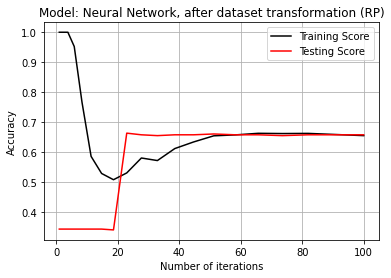

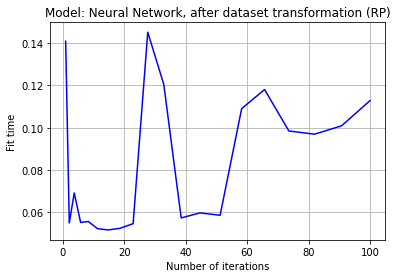

In [113]:
ica = FastICA(n_components=7)
ica.fit(X_train_diabetes)
I = (np.linspace(0.1,1,20))**2
X_train = pd.DataFrame(ica.transform(X_train_diabetes), columns=['Component '+str(i) for i in range(1, 7+1)])
X_test = pd.DataFrame(ica.transform(X_test_diabetes), columns=['Component '+str(i) for i in range(1, 7+1)])
y_train = np.array(y_train_diabetes)
y_test = np.array(y_test_diabetes)
X = pd.concat([X_train,X_test])
X.reset_index(drop=True, inplace=True)
y = np.concatenate((y_train, y_test), axis=0)
NN = MLPClassifier(hidden_layer_sizes=(20), learning_rate_init=0.001, activation='relu', max_iter=100)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(NN, X, y, cv=2, scoring='accuracy', train_sizes=I, return_times=True)
plt.figure()
plt.plot(100*I, train_scores[:,0], 'black', label='Training Score')
plt.plot(100*I, test_scores[:,0], 'red', label='Testing Score')
plt.title('Model: Neural Network, after dataset transformation (RP)')
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.figure()
plt.plot(100*I, fit_times[:,0], 'blue')
plt.title('Model: Neural Network, after dataset transformation (RP)')
plt.xlabel('Number of iterations')
plt.ylabel('Fit time')
plt.grid()

# RP

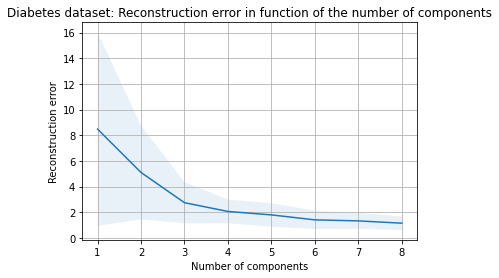

In [87]:
def reconstruction_error_RP(points, N):
    mean_r_errors = []
    std_r_errors = []
    for n in range(1, 1+N):
        temp = []
        for i in range(100):
            RP = GaussianRandomProjection(n_components=n)
            Diabetesrp = RP.fit_transform(points)
            recon = np.dot(Diabetesrp, RP.components_)
            temp.append(np.mean((np.array(points) - recon)**2))
        mean_r_errors.append(np.mean(temp))
        std_r_errors.append(np.std(temp))
    return mean_r_errors, std_r_errors

N = len(X_train_diabetes.columns)
means, std = reconstruction_error_RP(X_train_diabetes, 8)
plt.title('Diabetes dataset: Reconstruction error in function of the number of components')
plt.xlabel('Number of components')
plt.ylabel('Reconstruction error')
plt.grid()
plt.plot(range(1, N+1), means)
plt.xticks(range(1, N+1))
plt.fill_between(range(1, N+1), np.array(means)-np.array(std), np.array(means)+np.array(std), alpha=0.1)

0.002181529998779297


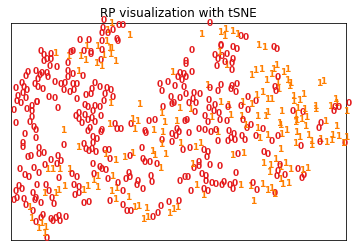

In [20]:
rp = GaussianRandomProjection(n_components=6)
t1 = time.time()
rp.fit(X_train_diabetes)
print(time.time()-t1)
X_rp_diabetes = pd.DataFrame(rp.transform(X_train_diabetes), columns=['Component '+str(i) for i in range(1, 6+1)])
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X_rp_diabetes)
plot_embedding(X_tsne, title="RP visualization with tSNE")

0 1 2 3 4 5 

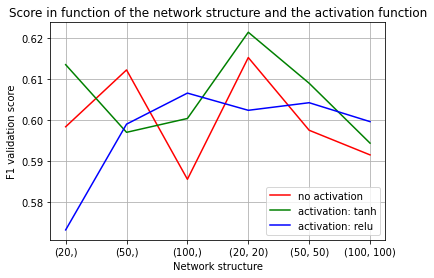

In [101]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
def select_neural_network(X_train, y_train, structures=[(20,), (50,),(100,),(20,20),(50,50,),(100,100,)], fit_per_step=2, multiclass='binary'):
    val_scores = np.zeros(len(structures))
    val_scores2 = np.zeros(len(structures))
    val_scores3 = np.zeros(len(structures))
    for i, structure in enumerate(structures):
        print(i, end=' ')
        for _ in range(fit_per_step):
            NN = MLPClassifier(hidden_layer_sizes=structure, learning_rate_init=0.01 if len(structure)==1 else 0.001, activation='identity', max_iter=60)
            cross_val = cross_validate(NN, X_train, y_train, cv=5, scoring='f1')
            val_scores[i] += statistics.mean(cross_val['test_score']) 
            NN = MLPClassifier(hidden_layer_sizes=structure, learning_rate_init=0.01 if len(structure)==1 else 0.001, activation='tanh', max_iter=60)
            cross_val = cross_validate(NN, X_train, y_train, cv=5, scoring='f1')
            val_scores2[i] += statistics.mean(cross_val['test_score'])
            NN = MLPClassifier(hidden_layer_sizes=structure, learning_rate_init=0.01 if len(structure)==1 else 0.001, activation='relu', max_iter=60)
            cross_val = cross_validate(NN, X_train, y_train, cv=5, scoring='f1')
            val_scores3[i] += statistics.mean(cross_val['test_score'])
        val_scores[i] /= fit_per_step
        val_scores2[i] /= fit_per_step
        val_scores3[i] /= fit_per_step
    plt.figure()
    plt.plot([str(s) for s in structures], val_scores, 'red', label='no activation')
    plt.plot([str(s) for s in structures], val_scores2, 'green', label='activation: tanh')
    plt.plot([str(s) for s in structures], val_scores3, 'blue', label='activation: relu')
    plt.title('Score in function of the network structure and the activation function')
    plt.xlabel('Network structure')
    plt.ylabel('F1 validation score')
    plt.legend()
    plt.grid()
RP = GaussianRandomProjection(n_components=6)
RP.fit(X_train_diabetes)
X_train = pd.DataFrame(RP.transform(X_train_diabetes), columns=['Component '+str(i) for i in range(1, 6+1)])
y_train = np.array(y_train_diabetes)
select_neural_network(X_train, y_train, multiclass='binary')

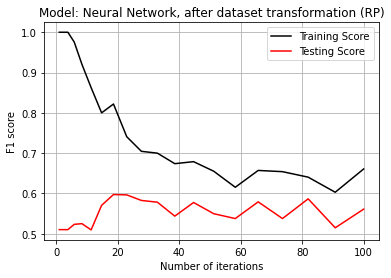

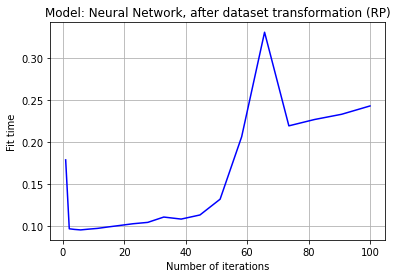

In [105]:
RP = GaussianRandomProjection(n_components=6)
RP.fit(X_train_diabetes)
I = (np.linspace(0.1,1,20))**2
X_train = pd.DataFrame(RP.transform(X_train_diabetes), columns=['Component '+str(i) for i in range(1, 6+1)])
X_test = pd.DataFrame(RP.transform(X_test_diabetes), columns=['Component '+str(i) for i in range(1, 6+1)])
y_train = np.array(y_train_diabetes)
y_test = np.array(y_test_diabetes)
X = pd.concat([X_train,X_test])
X.reset_index(drop=True, inplace=True)
y = np.concatenate((y_train, y_test), axis=0)
NN = MLPClassifier(hidden_layer_sizes=(50), learning_rate_init=0.001, activation='relu', max_iter=100)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(NN, X, y, cv=2, scoring='f1', train_sizes=I, return_times=True)
plt.figure()
plt.plot(100*I, train_scores[:,0], 'black', label='Training Score')
plt.plot(100*I, test_scores[:,0], 'red', label='Testing Score')
plt.title('Model: Neural Network, after dataset transformation (RP)')
plt.xlabel('Number of iterations')
plt.ylabel('F1 score')
plt.legend()
plt.grid()

plt.figure()
plt.plot(100*I, fit_times[:,0], 'blue')
plt.title('Model: Neural Network, after dataset transformation (RP)')
plt.xlabel('Number of iterations')
plt.ylabel('Fit time')
plt.grid()

# Random Forest

### Training

7.1909050941467285


<BarContainer object of 8 artists>

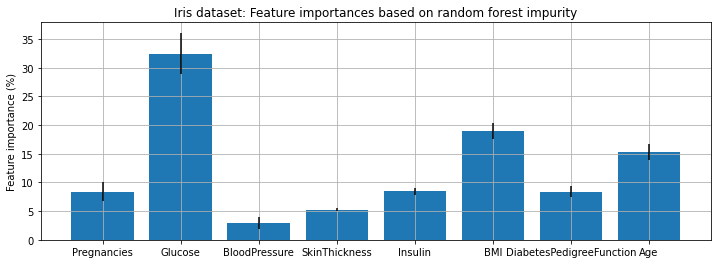

In [22]:
from sklearn.ensemble import RandomForestClassifier
def importances(points):
    importances = []
    for i in range(1, 6):
        RFC = RandomForestClassifier(n_estimators=1000, max_depth=i)
        RFC.fit(X_train_diabetes, y_train_diabetes)
        importances.append(list(RFC.feature_importances_))
    return np.mean(importances, axis=0), np.std(importances, axis=0)

t1 = time.time()
means, std = importances(X_train_diabetes)
print(time.time()-t1)
plt.figure(figsize=(12,4))
plt.title('Iris dataset: Feature importances based on random forest impurity')
plt.ylabel('Feature importance (%)')
plt.xticks(range(1, len(X_train_diabetes.columns)+1), X_train_diabetes.columns)
plt.grid()
plt.bar(range(1, len(X_train_diabetes.columns)+1), 100*means, yerr=100*std)

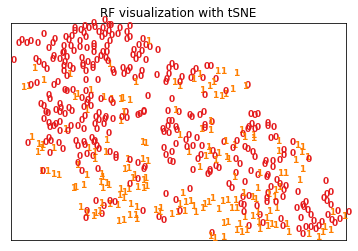

In [18]:
X_rf_diabetes = X_train_diabetes.iloc[:,[0,1,4,5,6,7]]
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X_rf_diabetes)
plot_embedding(X_tsne, title="RF visualization with tSNE")

### Neural Network

0 1 2 3 4 5 

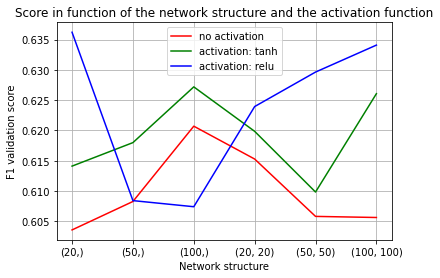

In [14]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
def select_neural_network(X_train, y_train, structures=[(20,), (50,),(100,),(20,20),(50,50,),(100,100,)], fit_per_step=3, multiclass='binary'):
    val_scores = np.zeros(len(structures))
    val_scores2 = np.zeros(len(structures))
    val_scores3 = np.zeros(len(structures))
    for i, structure in enumerate(structures):
        print(i, end=' ')
        for _ in range(fit_per_step):
            NN = MLPClassifier(hidden_layer_sizes=structure, learning_rate_init=0.01 if len(structure)==1 else 0.001, activation='identity', max_iter=60)
            cross_val = cross_validate(NN, X_train, y_train, cv=5, scoring='f1')
            val_scores[i] += statistics.mean(cross_val['test_score']) 
            NN = MLPClassifier(hidden_layer_sizes=structure, learning_rate_init=0.01 if len(structure)==1 else 0.001, activation='tanh', max_iter=60)
            cross_val = cross_validate(NN, X_train, y_train, cv=5, scoring='f1')
            val_scores2[i] += statistics.mean(cross_val['test_score'])
            NN = MLPClassifier(hidden_layer_sizes=structure, learning_rate_init=0.01 if len(structure)==1 else 0.001, activation='relu', max_iter=60)
            cross_val = cross_validate(NN, X_train, y_train, cv=5, scoring='f1')
            val_scores3[i] += statistics.mean(cross_val['test_score'])
        val_scores[i] /= fit_per_step
        val_scores2[i] /= fit_per_step
        val_scores3[i] /= fit_per_step
    plt.figure()
    plt.plot([str(s) for s in structures], val_scores, 'red', label='no activation')
    plt.plot([str(s) for s in structures], val_scores2, 'green', label='activation: tanh')
    plt.plot([str(s) for s in structures], val_scores3, 'blue', label='activation: relu')
    plt.title('Score in function of the network structure and the activation function')
    plt.xlabel('Network structure')
    plt.ylabel('F1 validation score')
    plt.legend()
    plt.grid()

X_train = X_train_diabetes.iloc[:,[0,1,4,5,6,7]]
y_train = np.array(y_train_diabetes)
select_neural_network(X_train, y_train, multiclass='binary')

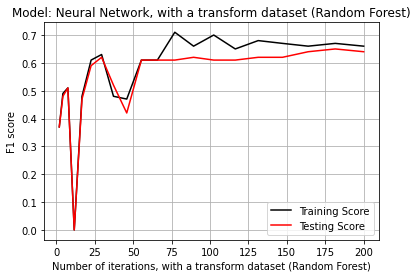

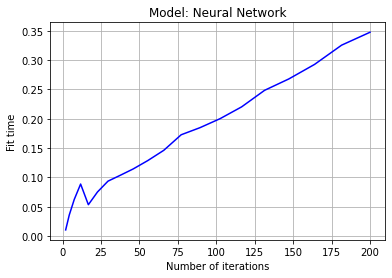

In [63]:
from sklearn.metrics import accuracy_score as accuracy
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
X_train = X_train_diabetes.iloc[:,[1,5,7]] #[:,[0,1,4,5,6,7]]
X_test = X_test_diabetes.iloc[:,[1,5,7]] #[0,1,4,5,6,7]]
y_train = np.array(y_train_diabetes)
y_test = np.array(y_test_diabetes)
n = 20
I = 200*(np.linspace(0.1,1,n))**2
train_time = np.zeros(n)
train_score = np.zeros(n)
val_score = np.zeros(n)
for c,i in enumerate(I):
    NN = MLPClassifier(hidden_layer_sizes=(20), learning_rate_init=0.001, activation='relu', max_iter=int(i))
    t1 = time.time()
    NN.fit(X_train,y_train)
    t2 = time.time()
    train_time[c] = t2-t1
    train_score[c] = round(f1_score(NN.predict(X_train),y_train, average='binary'),2)
    val_score[c] = round(f1_score(NN.predict(X_test),y_test, average='binary'),2)
plt.figure()
plt.plot(I, val_score, 'black', label='Training Score')
plt.plot(I, train_score, 'red', label='Testing Score')
plt.title('Model: Neural Network, with a transform dataset (Random Forest)')
plt.xlabel('Number of iterations, with a transform dataset (Random Forest)')
plt.ylabel('F1 score')
plt.legend()
plt.grid()

plt.figure()
plt.plot(I, train_time, 'blue')
plt.title('Model: Neural Network')
plt.xlabel('Number of iterations')
plt.ylabel('Fit time')
plt.grid()

# K-Means

## Training Diabetes

2 3 4 5 6 7 8 9 10 

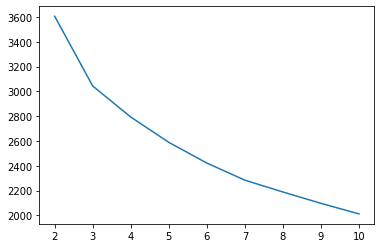

In [16]:
def SSE(points, kmax):
    sse = []
    for k in range(2, kmax+1):
        print(k, end=' ')
        kmeans = KMeans(n_clusters=k).fit(points)
        centroids = kmeans.cluster_centers_
        sse.append(kmeans.inertia_)
    return sse
kmax = 10
plt.plot(range(2, kmax+1), SSE(X_train_diabetes, kmax))

2 3 4 5 6 7 8 9 10 

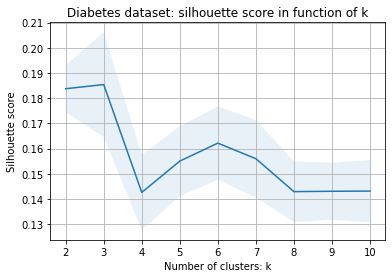

In [25]:
def silhouette(points, kmax):
    avg = []
    std = []
    for k in range(2, kmax+1):
        print(k, end=' ')
        kmeans = KMeans(n_clusters=k)
        cluster_labels = kmeans.fit_predict(X_train_diabetes)
        silhouette_avg = silhouette_score(X_train_diabetes, cluster_labels)
        avg.append(np.mean(silhouette_samples(X_train_diabetes, cluster_labels)))
        std.append(np.std(silhouette_samples(X_train_diabetes, cluster_labels)))
    return avg, std

kmax = 10
means, std = silhouette(X_train_diabetes, kmax)
plt.plot(range(2,kmax+1), means)
plt.title('Diabetes dataset: silhouette score in function of k')
plt.xlabel('Number of clusters: k')
plt.ylabel('Silhouette score')
plt.grid()
plt.fill_between(range(2,kmax+1), np.array(means)-np.array(std)**2, np.array(means)+np.array(std)**2, alpha=0.1)

## Evaluating Diabetes

In [27]:
def oneHot(y_pred):
    output = []
    for elem in y_pred:
        temp = [0, 0, 0]
        temp[elem] = 1
        output.append(temp)
    return output

kmeans = KMeans(n_clusters=3)
t1 = time.time()
kmeans.fit(X_train_diabetes)
print(time.time()-t1)
y_pred = kmeans.predict(X_train_diabetes)
#X_train = pd.DataFrame(y_pred_, columns=['Component '+str(i) for i in range(1, 3+1)])
homogeneity_completeness_v_measure(y_train_diabetes, y_pred)

0.17787599563598633


(0.12744778116450783, 0.07734545920244813, 0.09626789576490845)

### Neural Network

0 1 2 3 4 5 

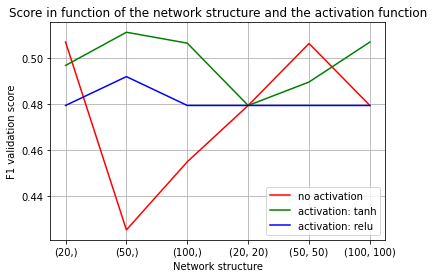

In [37]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
def select_neural_network(X_train, y_train, structures=[(20,), (50,),(100,),(20,20),(50,50,),(100,100,)], fit_per_step=3, multiclass='binary'):
    val_scores = np.zeros(len(structures))
    val_scores2 = np.zeros(len(structures))
    val_scores3 = np.zeros(len(structures))
    for i, structure in enumerate(structures):
        print(i, end=' ')
        for _ in range(fit_per_step):
            NN = MLPClassifier(hidden_layer_sizes=structure, learning_rate_init=0.01 if len(structure)==1 else 0.001, activation='identity', max_iter=60)
            cross_val = cross_validate(NN, X_train, y_train, cv=5, scoring='f1')
            val_scores[i] += statistics.mean(cross_val['test_score']) 
            NN = MLPClassifier(hidden_layer_sizes=structure, learning_rate_init=0.01 if len(structure)==1 else 0.001, activation='tanh', max_iter=60)
            cross_val = cross_validate(NN, X_train, y_train, cv=5, scoring='f1')
            val_scores2[i] += statistics.mean(cross_val['test_score'])
            NN = MLPClassifier(hidden_layer_sizes=structure, learning_rate_init=0.01 if len(structure)==1 else 0.001, activation='relu', max_iter=60)
            cross_val = cross_validate(NN, X_train, y_train, cv=5, scoring='f1')
            val_scores3[i] += statistics.mean(cross_val['test_score'])
        val_scores[i] /= fit_per_step
        val_scores2[i] /= fit_per_step
        val_scores3[i] /= fit_per_step
    plt.figure()
    plt.plot([str(s) for s in structures], val_scores, 'red', label='no activation')
    plt.plot([str(s) for s in structures], val_scores2, 'green', label='activation: tanh')
    plt.plot([str(s) for s in structures], val_scores3, 'blue', label='activation: relu')
    plt.title('Score in function of the network structure and the activation function')
    plt.xlabel('Network structure')
    plt.ylabel('F1 validation score')
    plt.legend()
    plt.grid()

kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_diabetes)
X_train = pd.DataFrame(oneHot(kmeans.predict(X_train_diabetes)), columns=['Component '+str(i) for i in range(1, 3+1)])
y_train = np.array(y_train_diabetes)
select_neural_network(X_train, y_train, multiclass='binary')

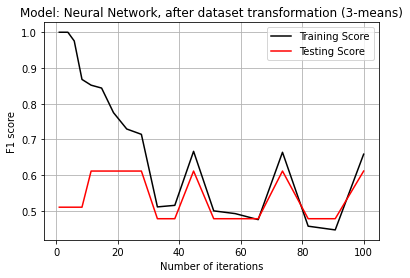

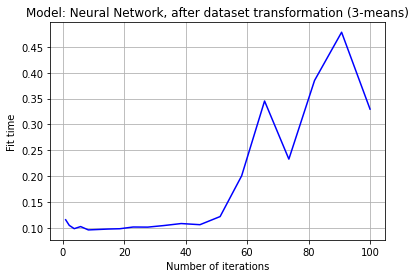

In [56]:
def oneHot(y_pred):
    output = []
    for elem in y_pred:
        temp = [0, 0, 0]
        temp[elem] = 1
        output.append(temp)
    return output
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_diabetes)
I = (np.linspace(0.1,1,20))**2
X_train = pd.DataFrame(oneHot(kmeans.predict(X_train_diabetes)), columns=['Component '+str(i) for i in range(1, 3+1)])
X_test = pd.DataFrame(oneHot(kmeans.predict(X_test_diabetes)), columns=['Component '+str(i) for i in range(1, 3+1)])
y_train = np.array(y_train_diabetes)
y_test = np.array(y_test_diabetes)
X = pd.concat([X_train,X_test])
X.reset_index(drop=True, inplace=True)
y = np.concatenate((y_train, y_test), axis=0)
NN = MLPClassifier(hidden_layer_sizes=(50), learning_rate_init=0.001, activation='relu', max_iter=100)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(NN, X, y, cv=2, scoring='f1', train_sizes=I, return_times=True)
plt.figure()
plt.plot(100*I, train_scores[:,0], 'black', label='Training Score')
plt.plot(100*I, test_scores[:,0], 'red', label='Testing Score')
plt.title('Model: Neural Network, after dataset transformation (3-means)')
plt.xlabel('Number of iterations')
plt.ylabel('F1 score')
plt.legend()
plt.grid()

plt.figure()
plt.plot(100*I, fit_times[:,0], 'blue')
plt.title('Model: Neural Network, after dataset transformation (3-means)')
plt.xlabel('Number of iterations')
plt.ylabel('Fit time')
plt.grid()

# Expectation Maximization

## Training Diabetes

2 3 4 5 6 7 8 9 10 

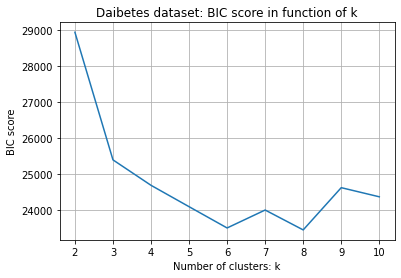

In [115]:
def BAIC_EM(points, kmax):
    bics = []
    aics = []
    for k in range(2, kmax+1):
        print(k, end=' ')
        test = 0
        test2 = 0
        for i in range(3):
            gmm = GaussianMixture(n_components=k)
            gmm.fit(points)
            test += gmm.bic(points)
            test2+= gmm.aic(points)
        bics.append(test)
        aics.append(test2)
    return bics, aics

kmax = 10
BIC, AIC = BAIC_EM(X_train_diabetes, kmax)
plt.plot(range(2, kmax+1), BIC)
plt.title('Daibetes dataset: BIC score in function of k')
plt.xlabel('Number of clusters: k')
plt.ylabel('BIC score')
plt.grid()

### Evaluation Diabetes

In [28]:
def oneHot(y_pred):
    output = []
    for elem in y_pred:
        temp = [0, 0, 0, 0, 0]
        temp[elem] = 1
        output.append(temp)
    return output

ExMa = GaussianMixture(n_components=5)
t1 = time.time()
ExMa.fit(X_train_diabetes)
print(time.time()-t1)
y_pred = ExMa.predict(X_train_diabetes)
homogeneity_completeness_v_measure(y_train_diabetes, y_pred)

0.23882579803466797


(0.1262646327009431, 0.05403232253296103, 0.07567927422570579)

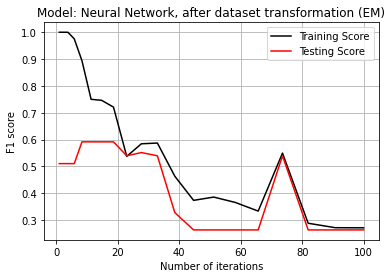

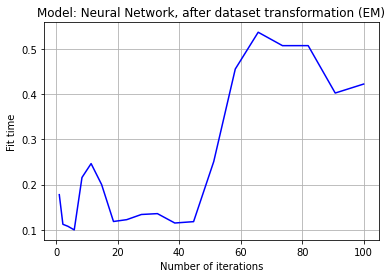

In [62]:
def oneHot(y_pred):
    output = []
    for elem in y_pred:
        temp = [0, 0, 0, 0, 0]
        temp[elem] = 1
        output.append(temp)
    return output

ExMa = GaussianMixture(n_components=5)
ExMa.fit(X_train_diabetes)
I = (np.linspace(0.1,1,20))**2
X_train = pd.DataFrame(oneHot(ExMa.predict(X_train_diabetes)), columns=['Component '+str(i) for i in range(1, 5+1)])
X_test = pd.DataFrame(oneHot(ExMa.predict(X_test_diabetes)), columns=['Component '+str(i) for i in range(1, 5+1)])
y_train = np.array(y_train_diabetes)
y_test = np.array(y_test_diabetes)
X = pd.concat([X_train,X_test])
X.reset_index(drop=True, inplace=True)
y = np.concatenate((y_train, y_test), axis=0)
NN = MLPClassifier(hidden_layer_sizes=(50), learning_rate_init=0.001, activation='relu', max_iter=100)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(NN, X, y, cv=2, scoring='f1', train_sizes=I, return_times=True)
plt.figure()
plt.plot(100*I, train_scores[:,0], 'black', label='Training Score')
plt.plot(100*I, test_scores[:,0], 'red', label='Testing Score')
plt.title('Model: Neural Network, after dataset transformation (EM)')
plt.xlabel('Number of iterations')
plt.ylabel('F1 score')
plt.legend()
plt.grid()

plt.figure()
plt.plot(100*I, fit_times[:,0], 'blue')
plt.title('Model: Neural Network, after dataset transformation (EM)')
plt.xlabel('Number of iterations')
plt.ylabel('Fit time')
plt.grid()

0 1 2 3 4 5 

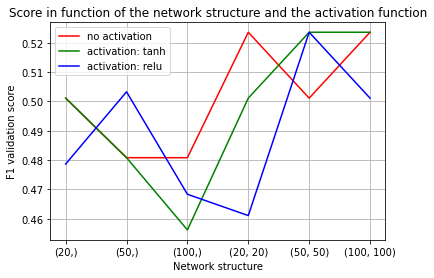

In [39]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
def select_neural_network(X_train, y_train, structures=[(20,), (50,),(100,),(20,20),(50,50,),(100,100,)], fit_per_step=3, multiclass='binary'):
    val_scores = np.zeros(len(structures))
    val_scores2 = np.zeros(len(structures))
    val_scores3 = np.zeros(len(structures))
    for i, structure in enumerate(structures):
        print(i, end=' ')
        for _ in range(fit_per_step):
            NN = MLPClassifier(hidden_layer_sizes=structure, learning_rate_init=0.01 if len(structure)==1 else 0.001, activation='identity', max_iter=60)
            cross_val = cross_validate(NN, X_train, y_train, cv=5, scoring='f1')
            val_scores[i] += statistics.mean(cross_val['test_score']) 
            NN = MLPClassifier(hidden_layer_sizes=structure, learning_rate_init=0.01 if len(structure)==1 else 0.001, activation='tanh', max_iter=60)
            cross_val = cross_validate(NN, X_train, y_train, cv=5, scoring='f1')
            val_scores2[i] += statistics.mean(cross_val['test_score'])
            NN = MLPClassifier(hidden_layer_sizes=structure, learning_rate_init=0.01 if len(structure)==1 else 0.001, activation='relu', max_iter=60)
            cross_val = cross_validate(NN, X_train, y_train, cv=5, scoring='f1')
            val_scores3[i] += statistics.mean(cross_val['test_score'])
        val_scores[i] /= fit_per_step
        val_scores2[i] /= fit_per_step
        val_scores3[i] /= fit_per_step
    plt.figure()
    plt.plot([str(s) for s in structures], val_scores, 'red', label='no activation')
    plt.plot([str(s) for s in structures], val_scores2, 'green', label='activation: tanh')
    plt.plot([str(s) for s in structures], val_scores3, 'blue', label='activation: relu')
    plt.title('Score in function of the network structure and the activation function')
    plt.xlabel('Network structure')
    plt.ylabel('F1 validation score')
    plt.legend()
    plt.grid()

kmeans = KMeans(n_clusters=5)
kmeans.fit(X_train_diabetes)
X_train = pd.DataFrame(oneHot(kmeans.predict(X_train_diabetes)), columns=['Component '+str(i) for i in range(1, 5+1)])
y_train = np.array(y_train_diabetes)
select_neural_network(X_train, y_train, multiclass='binary')